# A Tour Through Cuba's Emerging Real Estate Market
- in 2011, cuba made a real estate market.
- JUST RESIDENTIAL?

- people will be able to buy and sell property, and move when they want
- billions of dollars of property that has been undervalued for decades would be open for sale

### Why this matters
- this is really significant because free exchange of property is the foundation of capitalism (market economies need flexible use of space, creates wealth -> jumpstart other activities)
- potential impact: reshape cities, wealthy move to better areas, investment in those areas.
- emergence of classes, some people build wealth from it, some don’t
- more class conflict
- grow the economy, lift standard of living


### Quirks of the Market
- no history of transactions to guide prices
- no accurate, public records on transactions occurring now
- people have to buy with cash, because there’s no mortgage lending, but nobody has cash.

- market actors
- buyers: want to move into a smaller home (need to sell theirs), or have money from Cuban diaspora. Lots of people who want to just buy can’t because there’s little savings and no mortgage lending even if they have sufficiently high income.
- sellers: sell their current home to get a smaller one, jacking up prices in order to get maybe get a foreign buyer.
- so the regular thing of people wanting to buy a home to start a family, or sell their current home to buy a bigger house, isn’t in operation. it’s mostly locals who want to get a smaller house, or people with much bigger, outside money.

### Framing
first quantitative look at (some of) the market
what does it even look like? does it look like we’d expect?


THE DATA
- cubisima.com is cuban craigslist
- they have home listings
- they have very detailed data: the standard stuff, and amenities
- I scraped it going back to 2011 - right after the reform
- how scraper works: had to extract data from html
- a couple of listings on the site since before, but very few.
- missing last year of data, scraper running now.

PIC
- fields: property type, number of bedrooms, number of bathrooms, meters squared (incomplete), 
- neighborhood and city
- pub_date, day of week, month, year
- contact name, phone number, mobile number
- notes
- bunch of amenities
- PHOTOS AND VIEWS

exclude: construction_era, near_to, modified, mod_date, other info

- address sampling issues: what percent of the market?
- random sample? (is access to the internet even, are some types of properties more like to be on the site)
- how to interpret significant test for variables, relationships, regression coefficients


Overnight, a property market has re-emerged in a county that hasn't had on for 50 years. And because it did so in 2011, instead of in 2011, or 1981 for that matter, a part of the market is taking place only. 

Which gives us an unprecendeted oppotunity to observe the re-emergence of market in one of the World's oldest socialist economies.

What sort of market emerges when there's been nothing for 50 years? What emerges?

Is it growing? What type of property is being sold? Hold much is it going for? What are the drivers of price?

First, let's read in the data.

In [125]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
sns.set(style="whitegrid")
sns.set_color_codes('pastel')

In [273]:
raw_listings = pd.read_csv('../data/listings.csv')

## How many properties have been listed on Cubisima.com since the reforms?

In [182]:
def convert_pub_date(listings):
    '''
    Convert publication date to daytime. Listings posted on day scraper
    ran display time of posting - i.e. "8:35 am" - instead of the date ~
    24/12/2011. These must be transformed.
    '''
    # Get datetime of when the scraper ran.
    listings = listings.copy() # So this function can be rerun.
    listings_no_today = listings[~listings.pub_date.str.contains('am')]
    today = pd.to_datetime(listings_no_today.pub_date).max()
    # Set strings with format '8:35 am' to scraper run date.
    has_am = listings.pub_date.str.contains('am')
    listings.loc[has_am, 'pub_date'] = today
    # Convert all publication dates to to datetime.
    listings.loc[:,'pub_date'] = pd.to_datetime(listings['pub_date'])
    return listings

In [274]:
# Convert publication date to datetime.
listings_dt = convert_pub_date(raw_listings)
# Missing some listings after July 2014, so remove them.
lt_aug_2014 = listings_dt.pub_date < '08-01-2014'
gt_nov_2011 = listings_dt.pub_date >= '11-01-2011'
listings_since_reform = listings_dt[gt_nov_2011 & lt_aug_2014]

In [184]:
listings_since_reform.shape[0]

60365

**60,365 properties** were advertised on Cubisima.com between Nov 2011, when the reform were announced, and July 2014, the last month we current have data for.

## How much of the market does this represent?

By comparison, the Cuban government reported **80,000 completed property sales** in the first 11 months of 2013, according to a [2014 study](http://www.brookings.edu/~/media/research/files/reports/2014/02/21-cuba-real-estate/phil-peters-cubas-new-real-estate-market.pdf) by the Brookings Institution.

It's safe to assume that in these early days, only a small fraction of properties advertised on the site end up selling. (We can't tell from listings data which properties actually sold.) And it's very possible that some properties were listed multiple times in 2013. (I haven't yet tried to identify and remove duplicate listings.)

But the fact that 3 properties were listed for every 4 that sold across the island during that period suggest we may be capturing a decent sample of the market. If we assume one of every 50 properties listed on Cubisima.com eventually sold, then 1.5% of properties purchased during the period appeared on the site.

## Has the number of listings grown over time?

To whatever extent Cubisima reflects Cuba, a growing number of classifieds on the site could reflect the growth of the island's fledging property market. So next, let's take a look at listings over time.

In [192]:
# Make time series of listings per week.
listings_since_reform_ts = listings_since_reform.set_index(listings_since_reform.pub_date)
ts_listing_counts = listings_since_reform_ts['id'].resample('W', how='count')

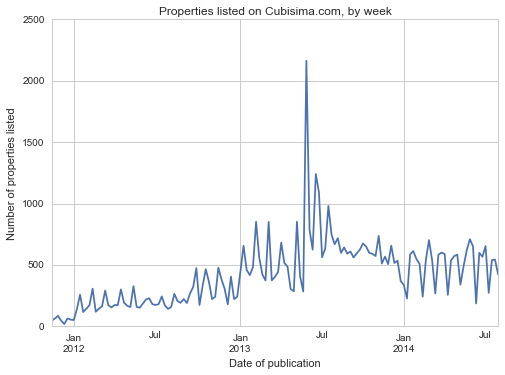

In [193]:
# Plot time series.
ts_listing_counts.plot()
plt.xlabel('Date of publication')
plt.ylabel('Number of properties listed')
plt.title('Properties listed on Cubisima.com, by week')

This plot shows the number of listings posted to the site every week.

Though not visible here, the earliest listings on Cubisima date from July 2011, months before property sales became legal on the island. (There are too few listings from this pre-reform period, however, for us to compare properties before vs. after.)


New listings jumped to 100-200 per week immediately Raul Castor announced the reforms in November 2011. They grew slowly during 2012, and then roughly doubled at the start of 2013. As of mid 2014, the number of new listings per week had stabilized at around 400 listings per week.

Notice, however, that listings tend to spike once month, and that size of this periodic variation grows over the years.

Before we can dig further, we must clean our dataset.

In [277]:
def clean_listings(listings):
    '''Coerce columns to have property data types.'''
    # Convert asking price from string to float. 
    # This dropes ~13K/63K listings with no asking price info.
    listings.loc[:, 'price'] = listings.price.str.replace(',','').astype(float).copy()
    # Remove price outliers from dataset.
    listings = listings[listings.price < 500000]
    # Convert blank listings notes to NaN.
    has_dash = (listings.notes == '-')
    listings.loc[has_dash, 'notes'] = np.NaN
    # The site allows people to list half rooms. Take the floor to simplify the data.
    listings.loc[:, 'num_bed'] = listings.num_bed.apply(lambda s: int(np.floor(s)))
    # Translate amenity columns to english.
    amenity_dict = {'azotea compartida': 'amenity_shared_rootop', 'balcon': 'amenity_balcony', 'corriente 220V': 'amenity_electricity_200V',
                    'sala-comedor': 'amenity_combined_living_and_dining_room', 'cocina': 'amenity_kitchen', 'piscina': 'amenity_pool',
                    'agua las 24 horas': 'amenity_water_all_day', 'garaje': 'amenity_garage', 'gas de balon': 'amenity_gas_tank',
                     'independiente': 'amenity_independent', 'patio': 'amenity_patio', 'tanque instalado': 'amenity_water_tank',
                     'bajos': 'amenity_bajos', 'telefono': 'amenity_telephone', 'placa libre': 'amenity_placa_libre',
                     'posibilidad de garaje': 'amenity_garage_possible', 'pasillo': 'amenity_hallway',
                     'corriente 110V': 'amenity_electricity_110V', 'interior': 'amenity_interior', 'puntal alto': 'amenity_high_ceilings',
                     'elevador': 'amenity_elevator', 'azotea libre': 'amenity_free_roof', 'terraza': 'amenity_terrace',
                     'patinejo': 'amenity_ventilation_shaft', 'puerta calle': 'amenity_street_facing_door', 'portal': 'amenity_portal',
                     'gas de la calle': 'amenity_gas_line', 'cocina-comedor': 'amenity_combined_kitchen_dinning_room', 'hall': 'amenity_hall',
                     'altos': 'amenity_altos', 'saleta': 'amenity_small_room', 'comedor': 'amenity_dining_room',
                     'barbacoa': 'amenity_barbeque', 'jardin': 'amenity_garden', 'carposhe': 'amenity_carposhe', 'sala': 'amenity_living_room'}
    listings.rename(columns=amenity_dict, inplace=True)
    # Translate property types to english.
    property_dict = {'property_type': {'Casa': 'House', 
                                       'Apartamento': 'Apartment',
                                       'Habitacion': 'Room',
                                       'Terreno': 'Empty Lot',
                                       'Prop  horizontal': 'Co-op'
                                      }}
    listings.replace(to_replace=property_dict, inplace=True)
    return listings

In [278]:
def make_additional_variables(listings):
    '''Construct additional listing variables from scraped data.'''
    # Construct day of week, month, and year variables.
    listings.loc[:, 'year'] = listings.pub_date.dt.year.astype(str)
    listings.loc[:, 'month'] = listings.pub_date.dt.month.astype(str)
    listings.loc[:, 'day_of_week'] = listings.pub_date.dt.dayofweek.astype(str)
    # Construct neighborhood and city variables.
    has_location = ~listings.location.isnull()
    listings.loc[:, 'province'] = listings[has_location].location.apply(lambda v: str(v).split(', ')[-1])
    listings.loc[:, 'city'] = listings[has_location].location.apply(lambda v: str(v).split(', ')[-2].split('en ')[-1])
    return listings

In [279]:
listings = make_additional_variables(clean_listings(listings_since_reform))

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/pandas/core/frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/pandas/core/generic.py:3050: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [280]:
listings.shape

(47740, 58)

Just over 20% of listings on Cubisima.com lack price information, so let's drop those records and focus on the universe of properties with listed prices. That leaves us with **47,740 properties** to analyze.

Let's also make some new variables. We can derive the day of week, month, and year a listing was first posted on the site from its publication date. And we can extract the city and provicence where each property is location from the "location" field of listings.

## What kind of properties are being listed on the site?

Cubans haven't been able to sell their residences since the early 1960s. Now that they suddenly can, what types of properties are they putting on the market?


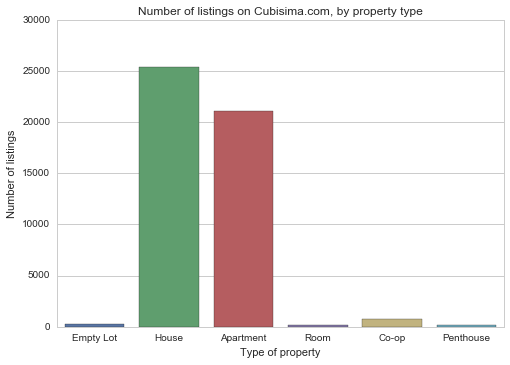

In [281]:
sns.countplot(listings.property_type)
plt.title('Number of listings on Cubisima.com, by property type')
plt.xlabel('Type of property')
plt.ylabel('Number of listings')

In [282]:
(listings.property_type.value_counts() / listings.shape[0]) * 100

House        53.206954
Apartment    44.178886
Co-op         1.499791
Empty Lot     0.578132
Room          0.278592
Penthouse     0.257646
Name: property_type, dtype: float64

Houses and apartments make up **97% of properties** on the site.

"Horizonal properties," Cuba's answer to Co-op apartments, are in (very distant) third place, with 1.5% of listings. Empty lots, single rooms, and luxury penthouses occasionally make an appearance.

Since houses and apartments dominate our dataset, let's focus on them and drill down further.

(-0.5, 7.5)

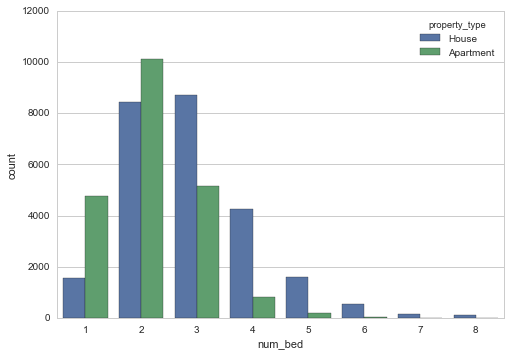

In [298]:
is_house = listings.property_type == 'Apartment'
is_apt = listings.property_type == 'House'
houses_and_apts = listings[is_house | is_apt]
sns.countplot('num_bed', hue='property_type', data=houses_and_apts)
plt.xlim((-.5,7.5))

(-0.5, 5.5)

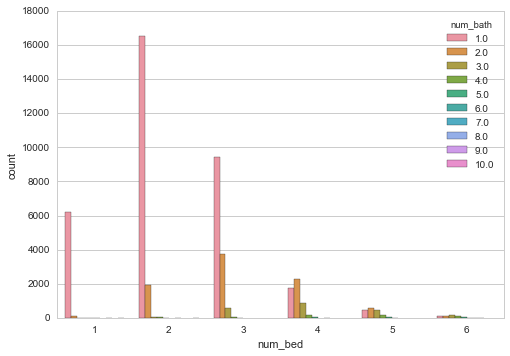

In [299]:
sns.countplot('num_bed', hue='num_bath', data=houses_and_apts)
plt.xlim((-.5,5.5))

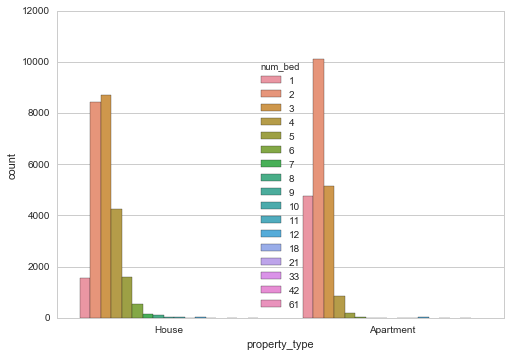

In [301]:
sns.countplot('property_type', hue='num_bed', data=houses_and_apts)

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


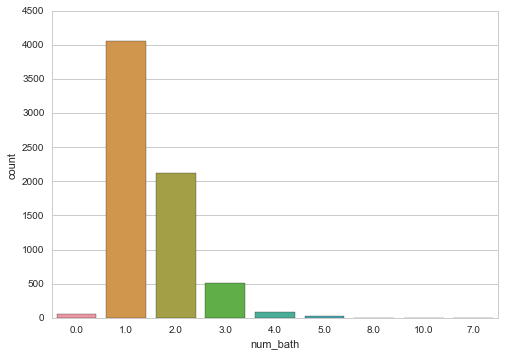

In [254]:
sns.countplot(listings.num_bath)

## How much are properties selling for?

(0, 500000)

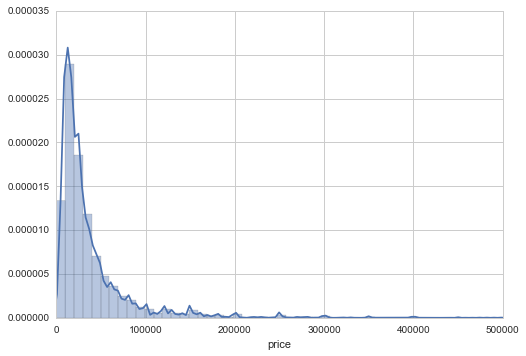

In [137]:
sns.distplot(listings.price)
plt.xlim((0,500000))

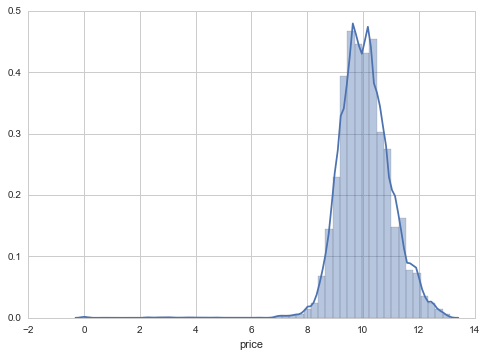

In [138]:
sns.distplot(np.log(listings.price))

## How have prices changed over time?

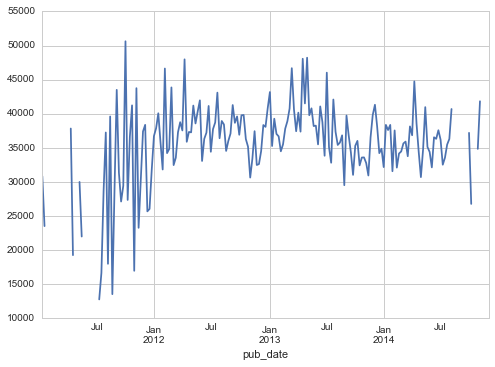

In [11]:
listings_dt.columns
listings_dt['price'].resample('W', how='mean').plot()

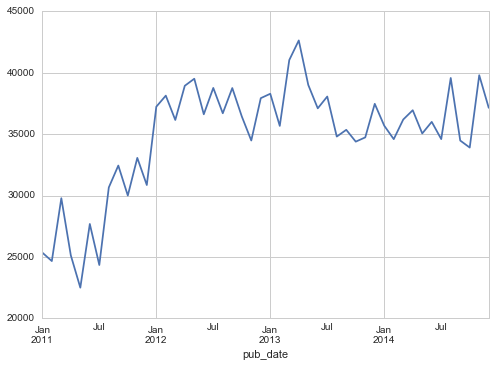

In [12]:
listings_dt['price'].resample('M', how='mean').plot()

## How does the size of a home affect its price?

In [10]:
#home_or_apt = (listings.property_type == 'Casa') | (listings.property_type == 'Apartamento')
#listings_home_apt = listings[home_or_apt]
# NOTE: 8510 listings have meters_squared values, 7730 are less than 500
has_meters = ~listings.meters_squared.isnull()
meters_lt_500 = listings.meters_squared < 500
listings_with_meters = listings[has_meters & meters_lt_500]
listings_with_meters.shape[0]

7730

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


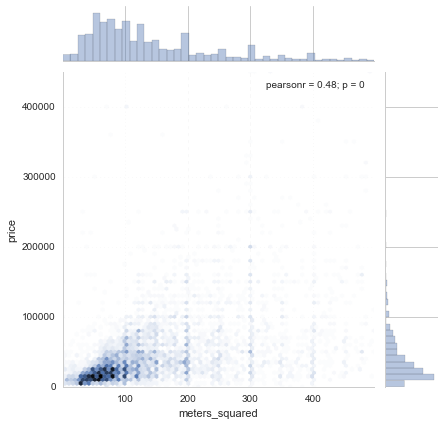

In [11]:
sns.jointplot('meters_squared', 'price', listings_with_meters, kind='hex')

In [12]:
listings[has_meters].shape

(8510, 53)

In [13]:
listings[has_meters & meters_lt_500].shape

(7730, 53)

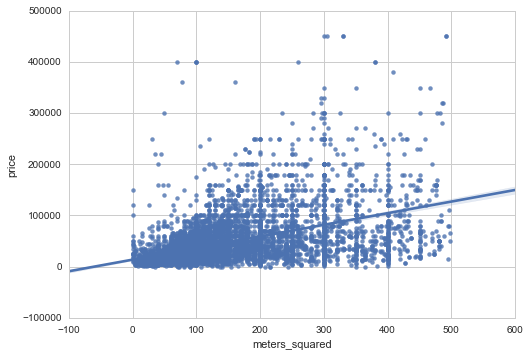

In [18]:
sns.regplot('meters_squared', 'price', listings_with_meters)

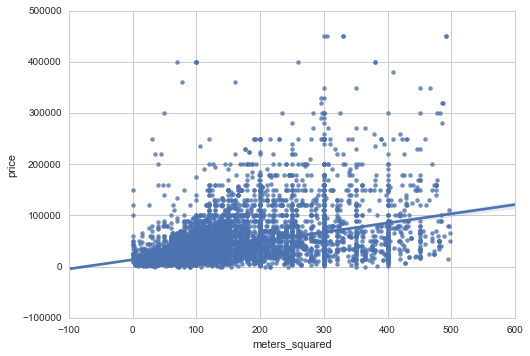

In [19]:
sns.regplot('meters_squared', 'price', listings_with_meters, robust=True)

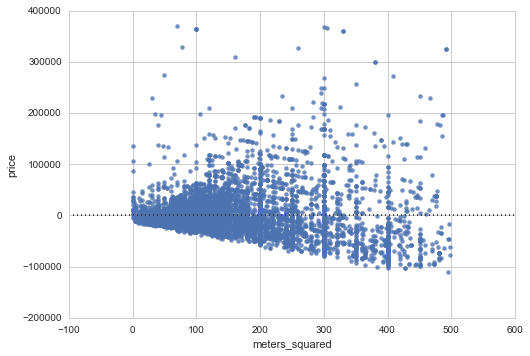

In [20]:
sns.residplot('meters_squared', 'price', listings_with_meters)

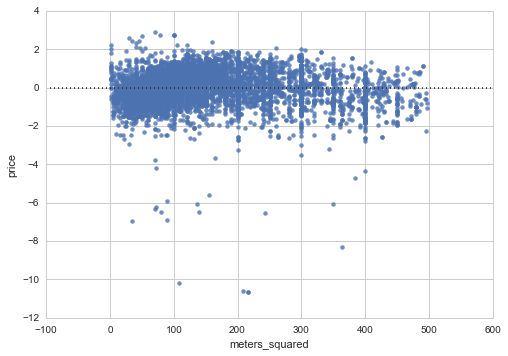

In [28]:
sns.residplot('meters_squared', np.log(listings_with_meters.price), listings_with_meters)

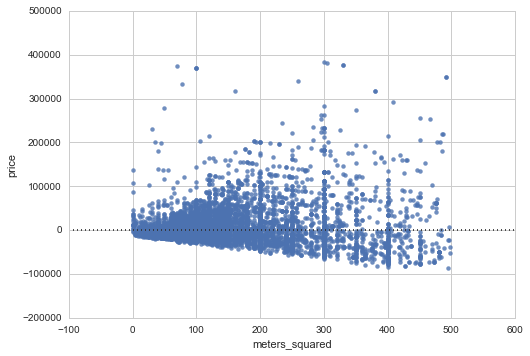

In [21]:
sns.residplot('meters_squared', 'price', listings_with_meters, robust=True)

## What's the distribution of rooms by property type?

The vast majority are homes or apartments.

ValueError: color kwarg must have one color per dataset

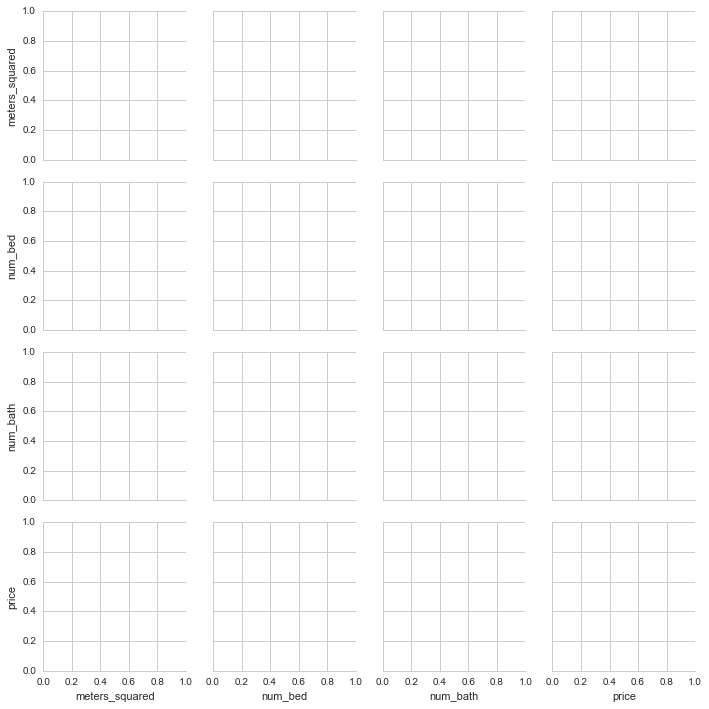

In [315]:
numerical_vars = ['meters_squared', 'num_bed', 'num_bath', 'price']
listings_home_apt = listings[(listings.property_type == 'Casa') | (listings.property_type == 'Apartamento')]
sns.pairplot(listings_home_apt, vars=numerical_vars, hue='property_type')

## How do prices vary by property type?

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0, 250000)

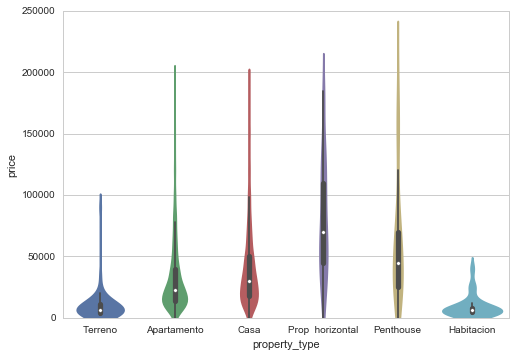

In [225]:
sns.violinplot(x=listings.property_type, y=listings.price)
plt.ylim((0,250000))

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


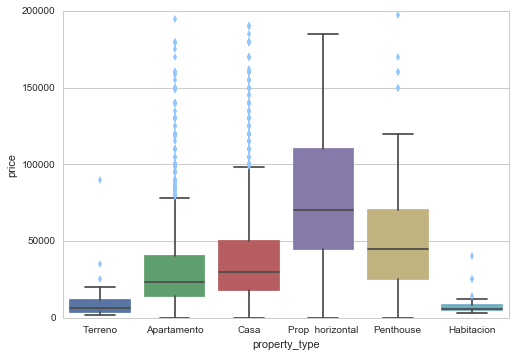

In [240]:
sns.boxplot(x=listings.property_type, y=listings.price)

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


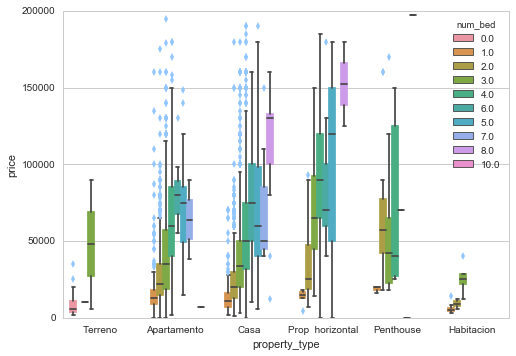

In [246]:
sns.boxplot(x=listings.property_type, hue=listings.num_bed.apply(np.floor), y=listings.price)

Houses have a higher mean and a heavier tail than apartments.
Penthouses cost more, and entire buildings the most.
Rooms and lots cost a lost less.

## How do prices vary by room?

In [229]:
listings.columns

Index(['azotea compartida', 'balcon', 'modified', 'corriente 220V',
       'sala-comedor', 'other_info', 'cocina', 'piscina', 'location',
       'agua las 24 horas', 'near_to', 'garaje', 'gas de balon',
       'independiente', 'patio', 'contact_name', 'tanque instalado', 'bajos',
       'telefono', 'placa libre', 'posibilidad de garaje', 'pasillo',
       'corriente 110V', 'interior', 'meters_squared', 'puntal alto',
       'num_bed', 'elevador', 'construction_era', 'num_bath', 'id',
       'azotea libre', 'terraza', 'mobile_number', 'price', 'patinejo',
       'puerta calle', 'pub_date', 'phone_number', 'portal', 'gas de la calle',
       'cocina-comedor', 'hall', 'altos', 'property_type', 'saleta', 'comedor',
       'barbacoa', 'jardin', 'notes', 'carposhe', 'sala', 'mod_date'],
      dtype='object')

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


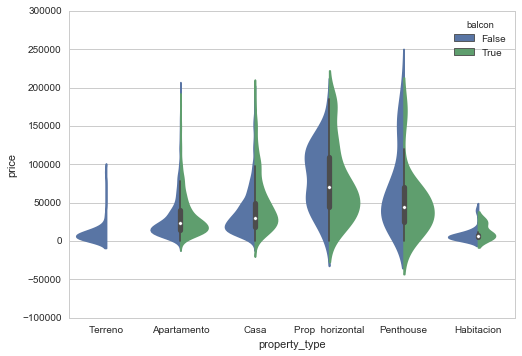

In [236]:
sns.violinplot(x=listings.property_type, hue=listings['balcon'], y=listings.price, split=True)

## Which property characteristics drive the price of real estate?

In [343]:
# Specify linear regression model. 
base_formula = '''price ~ property_type '''

# Construct formula of 36 property amenity boolean variables.
amenity_variables = [col_name for col_name in listings.columns.tolist() if 'amenity' in col_name]
amenities_formula =' + '.join(amenity_variables)

formula = base_formula #+ ' + ' + amenities_formula
y, X = dmatrices(formula, data=listings, return_type='dataframe')

In [344]:
# Regress price on property characteristics, amenities, location, and time variables.
model = sm.OLS(y, X)
results = model.fit()

# Print regression diagnostics.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     747.3
Date:                Sun, 31 Jan 2016   Prob (F-statistic):               0.00
Time:                        22:01:31   Log-Likelihood:            -5.7656e+05
No. Observations:               47740   AIC:                         1.153e+06
Df Residuals:                   47734   BIC:                         1.153e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [339]:
# Specify model with meters squared.
formula_meters_squared = base_formula + ' + meters_squared + ' + amenities_formula
y_meters, X_meters = dmatrices(formula_meters_squared, data=listings, return_type='dataframe')

In [341]:
# Regress price on all variables in first model, plus meters squared.
model_meters = sm.OLS(y_meters, X_meters)
results_meters = model_meters.fit()

# Print regression diagnostics.
print(results_meters.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     68.94
Date:                Sun, 31 Jan 2016   Prob (F-statistic):               0.00
Time:                        21:55:20   Log-Likelihood:                -94787.
No. Observations:                7986   AIC:                         1.899e+05
Df Residuals:                    7809   BIC:                         1.912e+05
Df Model:                         176                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------

In [340]:
X_meters.shape

(7986, 224)

In [342]:
model = sm.OLS(np.log(y), X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     279.4
Date:                Sun, 31 Jan 2016   Prob (F-statistic):               0.00
Time:                        21:56:54   Log-Likelihood:                -44164.
No. Observations:               47350   AIC:                         8.876e+04
Df Residuals:                   47134   BIC:                         9.065e+04
Df Model:                         215                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------

In [52]:
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
results = rlm_model.fit()
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  price   No. Observations:                50463
Model:                            RLM   Df Residuals:                    50419
Method:                          IRLS   Df Model:                           43
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 29 Jan 2016                                         
Time:                        13:16:48                                         
No. Iterations:                    15                                         
                                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Interc

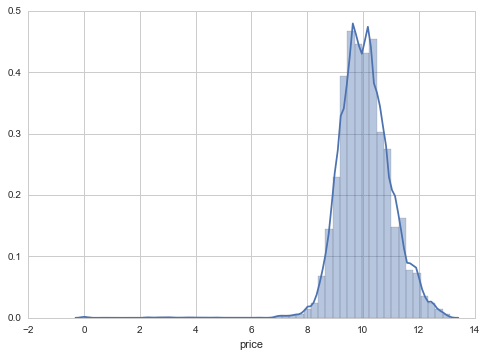

In [33]:
sns.distplot(np.log(listings.price))